# HSCT survival: data cleaning and encoding

## Notebook set-up

## Imports & options

In [1]:
# PyPI imports
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

# Internal imports
import configuration as config
import functions.encoding as encode_funcs
import functions.helper as helper_funcs

pd.set_option('display.max_rows', 500)

### Parameters

#### Dataset generation

In [2]:
# Run options
rebuild_datasets=False

# Some cleaning/encoding options
knn_neighbors=5
one_hot_drop, collinearity='first', 'no-multicollinearity'

#### Dataset testing

In [3]:
# Run options
test_datasets=True
randomsearch_depth=1000

# Define the hyperparameter search space for gradient boosting regression
distributions={
    'learning_rate': stats.uniform(loc=0.0, scale=1.0),
    'max_iter': list(range(10, 5000)),
    'max_leaf_nodes': list(range(2, 1000)),
    'max_depth': list(range(2, 1000)),
    'min_samples_leaf': list(range(1, 1000)),
    'l2_regularization': stats.uniform(loc=0.0, scale=1.0),
    'max_features': stats.uniform(loc=0.1, scale=0.9),
    'max_bins': list(range(2, 255)),
    'interaction_cst': ['pairwise', 'no_interactions']
}

### Files

#### Dataset generation

In [4]:
# Base data input file: ID column set as index, missing string placeholders converted to nan
# ordinal categorical features translated to numerical categorical where possible
translated_features_file=f'{config.DATA_PATH}/processed/01.1-features_translated.pkl'

# Feature data type definition file
feature_types_dict_file=f'{config.DATA_PATH}/processed/01.1-feature_type_dict.pkl'

# Nominal and ordinal features ordinal encoded.
# NAN values encoded as 'missing' for categorical features
# and KNN imputed for numerical features.
ordinal_all_nan_encoded_data_df_file=f'{config.DATA_PATH}/processed/02.1-{collinearity}_ordinal_all_nan_encoded_data_df.parquet'

# Nominal and ordinal features ordinal encoded encoded.
# NANs filled in by KNN imputation for all features.
ordinal_all_nan_imputed_data_df_file=f'{config.DATA_PATH}/processed/02.1-{collinearity}_ordinal_all_nan_imputed_data_df.parquet'

# Nominal features one hot encoded, ordinal features ordinal encoded. 
# Data with with NAN values encoded as missing for categorical features 
# and KNN imputed for numerical features.
one_hot_ordinal_nan_encoded_data_df_file=f'{config.DATA_PATH}/processed/02.1-{collinearity}_one_hot_ordinal_nan_encoded_data_df.parquet'

# Nominal features one hot encoded, ordinal features ordinal encoded.
# NANs filled in by KNN imputation for all features.
one_hot_ordinal_nan_imputed_data_df_file=f'{config.DATA_PATH}/processed/02.1-{collinearity}_one_hot_ordinal_nan_imputed_data_df.parquet'

# All ordinal and nominal features target encoded on EFS
binary_target_encoded_data_file=f'{config.DATA_PATH}/processed/02.1-binary_target_encoded_data_df'

# All ordinal and nominal features target encoded on EFS time
continuous_target_encoded_data_file=f'{config.DATA_PATH}/processed/02.1-continuous_target_encoded_data_df'

# Save dataset definitions
datasets={
    'Nominal one-hot/ordinal encoded, NANs encoded':one_hot_ordinal_nan_encoded_data_df_file,
    'Nominal one-hot/ordinal encoded, NANs imputed':one_hot_ordinal_nan_imputed_data_df_file,
    'All ordinal encoded, NAN encoded':ordinal_all_nan_encoded_data_df_file,
    'All ordinal encoded, NAN imputed':ordinal_all_nan_imputed_data_df_file,
    'Binary target encoded':binary_target_encoded_data_file,
    'Continuous target encoded':continuous_target_encoded_data_file
}

# Dataset definition file
datasets_file=f'{config.DATA_PATH}/processed/02.1-dataset_definitions.pkl'

# Save the dataset metadata
with open(datasets_file, 'wb') as output_file:
    pickle.dump(datasets, output_file)

#### Dataset testing

In [5]:
# Dataset testing results
datasets_test_results_file=f'{config.DATA_PATH}/results/data/01.2-datasets_test_results.pkl'
datasets_test_performance_plots=f'{config.DATA_PATH}/results/plots/01.2-datasets_test_performance.jpg'
datasets_test_residuals_plots=f'{config.DATA_PATH}/results/plots/01.2-datasets_test_residuals.jpg'

## 1. Input data

### 1.1. Feature type definitions

In [6]:
# Load the feature data type definitions
with open(feature_types_dict_file, 'rb') as input_file:
    feature_types_dict=pickle.load(input_file)

print('Feature types:\n')

for feature_type, features in feature_types_dict.items():
    print(f'{feature_type}\n{features}\n')

Feature types:

Interval
['donor_age', 'age_at_hct']

Ordinal
['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

Nominal
['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'prod_type', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']

Labels
['efs', 'e

### 1.2. Data

In [7]:
if rebuild_datasets == True:
    
    # Load the dataset
    data_df=pd.read_parquet(translated_features_file)

    # Remove and preserve the labels
    labels_df=data_df[['efs','efs_time']]
    data_df.drop(['efs','efs_time'], axis=1, inplace=True)

    # Save the unencoded 'race_group' feature
    race_group=data_df['race_group']

## 2. Encoding and NAN handling schemes

### 2.1. One-hot encode nominal features with missing value string

In [8]:
if rebuild_datasets == True:
    # Load the dataset
    data_df=pd.read_parquet(translated_features_file)

    # Remove and preserve the labels
    labels_df=data_df[['efs','efs_time']]
    data_df.drop(['efs','efs_time'], axis=1, inplace=True)

    # Save the unencoded 'race_group' feature
    race_group=data_df['race_group']

    # Encode the nominal features
    encoded_nominal_features_df=encode_funcs.one_hot_nan_encoded(
        data_df,
        feature_types_dict['Nominal']
    )

    # Encode the ordinal features
    encoded_ordinal_features_df=encode_funcs.ordinal_encode_nan_imputed(
        data_df,
        feature_types_dict['Ordinal']
    )

    # Clean NANs in the interval features
    cleaned_interval_features_df=encode_funcs.impute_numerical_features(
        data_df,
        feature_types_dict['Interval']
    )

    # Join the data back together
    result_df=pd.concat([encoded_nominal_features_df, encoded_ordinal_features_df, cleaned_interval_features_df], axis=1)
    print(f'Re-combined data: {result_df.shape}')

    # Add back the labels
    result_df=pd.concat([result_df, labels_df], axis=1)
    print(f'Labeled re-combined data: {data_df.shape}\n')

    # Add back un-encoded race group
    result_df['race_group']=race_group

    # Save
    result_df.to_parquet(one_hot_ordinal_nan_encoded_data_df_file)

    # Inspect
    result_df.info(verbose=True, show_counts=True)

### 2.2. One-hot encode nominal features with missing value imputation

In [9]:
if rebuild_datasets == True:

    # Load the dataset
    data_df=pd.read_parquet(translated_features_file)

    # Remove and preserve the labels
    labels_df=data_df[['efs','efs_time']]
    data_df.drop(['efs','efs_time'], axis=1, inplace=True)

    # Save the unencoded 'race_group' feature
    race_group=data_df['race_group']

    # Encode the nominal features
    encoded_nominal_features_df=encode_funcs.one_hot_encode_nan_imputed(
        data_df,
        feature_types_dict['Nominal']
    )

    # Encode the ordinal features
    encoded_ordinal_features_df=encode_funcs.ordinal_encode_nan_imputed(
        data_df,
        feature_types_dict['Ordinal']
    )

    # Clean NANs in the interval features
    cleaned_interval_features_df=encode_funcs.impute_numerical_features(
        data_df,
        feature_types_dict['Interval']
    )

    # Join the data back together
    result_df=pd.concat([encoded_nominal_features_df, encoded_ordinal_features_df, cleaned_interval_features_df], axis=1)
    print(f'\nRe-combined data: {result_df.shape}')

    # Add back the labels
    result_df=pd.concat([result_df, labels_df], axis=1)
    print(f'Labeled re-combined data: {data_df.shape}\n')

    # Add back un-encoded race group
    result_df['race_group']=race_group

    # Save
    result_df.to_parquet(one_hot_ordinal_nan_imputed_data_df_file)

    # Inspect
    result_df.info(verbose=True, show_counts=True)

### 2.3. Label encode nominal and ordinal features with 'missing' level

In [10]:
if rebuild_datasets == True:
    # Load the dataset
    data_df=pd.read_parquet(translated_features_file)

    # Remove and preserve the labels
    labels_df=data_df[['efs','efs_time']]
    data_df.drop(['efs','efs_time'], axis=1, inplace=True)

    # Save the unencoded 'race_group' feature
    race_group=data_df['race_group']

    # Encode the nominal & ordinal features
    encoded_categorical_features_df=encode_funcs.ordinal_encode_nan_encoded(
        data_df,
        feature_types_dict['Nominal'] + feature_types_dict['Ordinal']
    )

    # Clean NANs in the interval features
    cleaned_interval_features_df=encode_funcs.impute_numerical_features(
        data_df,
        feature_types_dict['Interval']
    )

    # Join the data back together
    result_df=pd.concat([encoded_categorical_features_df, cleaned_interval_features_df], axis=1)
    print(f'Re-combined data: {result_df.shape}')

    # Add back the labels
    result_df=pd.concat([result_df, labels_df], axis=1)
    print(f'Labeled re-combined data: {data_df.shape}\n')

    # Add back un-encoded race group
    result_df['race_group']=race_group

    # Save
    result_df.to_parquet(ordinal_all_nan_encoded_data_df_file)

    # Inspect
    result_df.info(verbose=True, show_counts=True)

### 2.4. Label encode nominal and ordinal features with NAN imputation

In [11]:
if rebuild_datasets == True:

    # Load the dataset
    data_df=pd.read_parquet(translated_features_file)

    # Remove and preserve the labels
    labels_df=data_df[['efs','efs_time']]
    data_df.drop(['efs','efs_time'], axis=1, inplace=True)

    # Save the unencoded 'race_group' feature
    race_group=data_df['race_group']

    # Encode the nominal & ordinal features
    encoded_categorical_features_df=encode_funcs.ordinal_encode_nan_imputed(
        data_df,
        feature_types_dict['Nominal'] + feature_types_dict['Ordinal']
    )

    # Clean NANs in the interval features
    cleaned_interval_features_df=encode_funcs.impute_numerical_features(
        data_df,
        feature_types_dict['Interval']
    )

    # Join the data back together
    result_df=pd.concat([encoded_categorical_features_df, cleaned_interval_features_df], axis=1)
    print(f'Re-combined data: {result_df.shape}')

    # Add back the labels
    result_df=pd.concat([result_df, labels_df], axis=1)
    print(f'Labeled re-combined data: {data_df.shape}\n')

    # Add back un-encoded race group
    result_df['race_group']=race_group

    # Save
    result_df.to_parquet(ordinal_all_nan_imputed_data_df_file)

    # Inspect
    result_df.info(verbose=True, show_counts=True)

### 2.5. Binary target encode everything on efs

In [12]:
if rebuild_datasets == True:

    # Load the dataset
    data_df=pd.read_parquet(translated_features_file)

    # Remove and preserve the labels
    labels_df=data_df[['efs','efs_time']]
    data_df.drop(['efs','efs_time'], axis=1, inplace=True)

    # Save the unencoded 'race_group' feature
    race_group=data_df['race_group']

    # Encode the nominal & ordinal features
    encoder=TargetEncoder()
    encoded_categorical_features=encoder.fit_transform(data_df[feature_types_dict['Nominal'] + feature_types_dict['Ordinal']], labels_df['efs'])

    encoded_categorical_features_df=pd.DataFrame(
        encoded_categorical_features,
        columns=feature_types_dict['Nominal'] + feature_types_dict['Ordinal']
    )

    # Clean NANs in the interval features
    cleaned_interval_features_df=encode_funcs.impute_numerical_features(
        data_df,
        feature_types_dict['Interval']
    )

    # Join the data back together
    result_df=pd.concat([encoded_categorical_features_df, cleaned_interval_features_df], axis=1)
    print(f'Re-combined data: {result_df.shape}')

    # Add back the labels
    result_df=pd.concat([result_df, labels_df], axis=1)
    print(f'Labeled re-combined data: {data_df.shape}\n')

    # Add back un-encoded race group
    result_df['race_group']=race_group

    # Save
    result_df.to_parquet(binary_target_encoded_data_file)

    # Inspect
    result_df.info(verbose=True, show_counts=True)

### 2.6. Continuous target encode everything on efs_time

In [13]:
if rebuild_datasets == True:

    # Load the dataset
    data_df=pd.read_parquet(translated_features_file)

    # Remove and preserve the labels
    labels_df=data_df[['efs','efs_time']]
    data_df.drop(['efs','efs_time'], axis=1, inplace=True)

    # Save the unencoded 'race_group' feature
    race_group=data_df['race_group']

    # Encode the nominal & ordinal features
    encoder=TargetEncoder()
    encoded_categorical_features=encoder.fit_transform(data_df[feature_types_dict['Nominal'] + feature_types_dict['Ordinal']], labels_df['efs_time'])

    encoded_categorical_features_df=pd.DataFrame(
        encoded_categorical_features,
        columns=feature_types_dict['Nominal'] + feature_types_dict['Ordinal']
    )

    # Clean NANs in the interval features
    cleaned_interval_features_df=encode_funcs.impute_numerical_features(
        data_df,
        feature_types_dict['Interval']
    )

    # Join the data back together
    result_df=pd.concat([encoded_categorical_features_df, cleaned_interval_features_df], axis=1)
    print(f'Re-combined data: {result_df.shape}')

    # Add back the labels
    result_df=pd.concat([result_df, labels_df], axis=1)
    print(f'Labeled re-combined data: {data_df.shape}\n')

    # Add back un-encoded race group
    result_df['race_group']=race_group

    # Save
    result_df.to_parquet(continuous_target_encoded_data_file)

    # Inspect
    result_df.info(verbose=True, show_counts=True)

## 3. Performance test: gradient boosting regression model

### 3.1. Hyperparameter optimization

In [14]:
if test_datasets == True:

    predictions={}
    labels={}
    best_parameters={}
    models={}
    race_groups={}

    # Define cross-validation strategy
    cross_validation=ShuffleSplit(n_splits=10, test_size=0.3, random_state=315)

    # Loop on the datasets
    for dataset, data_file in datasets.items():

        # Load the data
        data_df=pd.read_parquet(data_file)

        # Take log of efs time
        data_df['efs_time']=np.log(data_df['efs_time'])

        # Train test split
        training_df, testing_df=train_test_split(data_df, test_size=0.3, random_state=315)

        # Save the testing race group and drop from training and testing
        race_groups[dataset]=testing_df['race_group']
        training_df.drop('race_group', axis=1, inplace=True)
        testing_df.drop('race_group', axis=1, inplace=True)

        # Remove the labels
        training_labels_df=training_df[['efs', 'efs_time']].copy()
        training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)
        testing_labels_df=testing_df[['efs', 'efs_time']].copy()
        testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

        # Instantiate the model
        tree_model=HistGradientBoostingRegressor(random_state=315)

        # Set-up the search
        search=RandomizedSearchCV(
            tree_model,
            distributions,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            cv=cross_validation,
            n_iter=randomsearch_depth,
            random_state=315,
            return_train_score=True
        )

        search_results=search.fit(training_features_df, training_labels_df['efs'])
        best_parameters[dataset]=search_results.best_params_
        print(f'{dataset} winning parameters: {search_results.best_params_}')

        # Train classifier with best hyperparameters on complete training set
        tree_model=HistGradientBoostingRegressor(**search_results.best_params_, random_state=315)
        result=tree_model.fit(training_features_df, training_labels_df['efs'])
        models[dataset]=tree_model

        # Make testing predictions
        testing_predictions=tree_model.predict(testing_features_df)
        predictions[dataset]=testing_predictions
        labels[dataset]=testing_labels_df

    datasets_test_results={'Testing predictions': predictions}
    datasets_test_results['Testing labels']=labels
    datasets_test_results['Best parameters']=best_parameters
    datasets_test_results['Tuned models']=models
    datasets_test_results['Race groups']=race_groups

    with open(datasets_test_results_file, 'wb') as output_file:
        pickle.dump(datasets_test_results, output_file)

else:

    # Load last result
    with open(datasets_test_results_file, 'rb') as input_file:
        datasets_test_results=pickle.load(input_file)

    predictions=datasets_test_results['Testing predictions']
    labels=datasets_test_results['Testing labels']
    best_parameters=datasets_test_results['Best parameters']
    models=datasets_test_results['Tuned models']
    race_groups=datasets_test_results['Race groups']

Nominal one-hot/ordinal encoded, NANs encoded winning parameters: {'interaction_cst': 'pairwise', 'l2_regularization': 0.6378949377946339, 'learning_rate': 0.2373000683212062, 'max_bins': 216, 'max_depth': 675, 'max_features': 0.35616831556319695, 'max_iter': 1369, 'max_leaf_nodes': 283, 'min_samples_leaf': 268}
Nominal one-hot/ordinal encoded, NANs imputed winning parameters: {'interaction_cst': 'pairwise', 'l2_regularization': 0.6378949377946339, 'learning_rate': 0.2373000683212062, 'max_bins': 216, 'max_depth': 675, 'max_features': 0.35616831556319695, 'max_iter': 1369, 'max_leaf_nodes': 283, 'min_samples_leaf': 268}
All ordinal encoded, NAN encoded winning parameters: {'interaction_cst': 'no_interactions', 'l2_regularization': 0.17514759571704763, 'learning_rate': 0.9514868133617367, 'max_bins': 18, 'max_depth': 207, 'max_features': 0.5297635167330084, 'max_iter': 2359, 'max_leaf_nodes': 215, 'min_samples_leaf': 125}
All ordinal encoded, NAN imputed winning parameters: {'interactio

### 3.2. Results

#### 3.2.1. Scores

In [18]:
scoring_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

for dataset in predictions.keys():

    scoring_results=helper_funcs.score_predictions(
        dataset,
        predictions[dataset],
        labels[dataset]['efs_time'].values,
        labels[dataset]['efs'].values,
        race_groups[dataset],
        labels[dataset].index,
        results=scoring_results
    )

scoring_results_df=pd.DataFrame(scoring_results)
scoring_results_df.head(len(scoring_results_df))

,Model,RMSE,C-index,Stratified C-index
0,"Nominal one-hot/ordinal encoded, NANs encoded",2.354183,0.347945,0.331569
1,"Nominal one-hot/ordinal encoded, NANs imputed",2.354183,0.347945,0.331569
2,"All ordinal encoded, NAN encoded",2.358565,0.342542,0.325161
3,"All ordinal encoded, NAN imputed",2.359940,0.342372,0.324176
4,Binary target encoded,2.358455,0.341473,0.325246
5,Continuous target encoded,2.354654,0.346680,0.329730


#### 3.2.2. Prediction plots

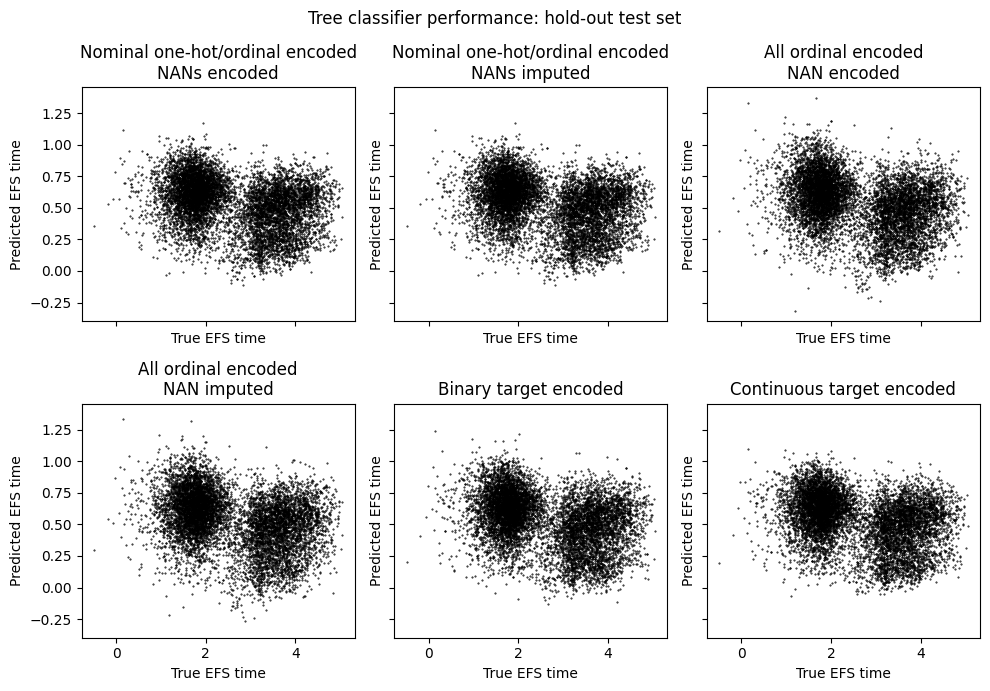

In [19]:
fig, axs=plt.subplots(2,3, figsize=(10,7), sharex=True, sharey=True)
axs=axs.flatten()

fig.suptitle('Tree classifier performance: hold-out test set')

for i, dataset in enumerate(predictions.keys()):

    axs[i].set_title(dataset.replace(', ', '\n'))
    axs[i].scatter(labels[dataset]['efs_time'], predictions[dataset], color='black', s=0.2)
    axs[i].set_xlabel('True EFS time')
    axs[i].set_ylabel('Predicted EFS time')

fig.tight_layout()
fig.savefig(datasets_test_performance_plots, dpi=300, bbox_inches='tight')
fig.show()

#### 3.2.2. Residual plots

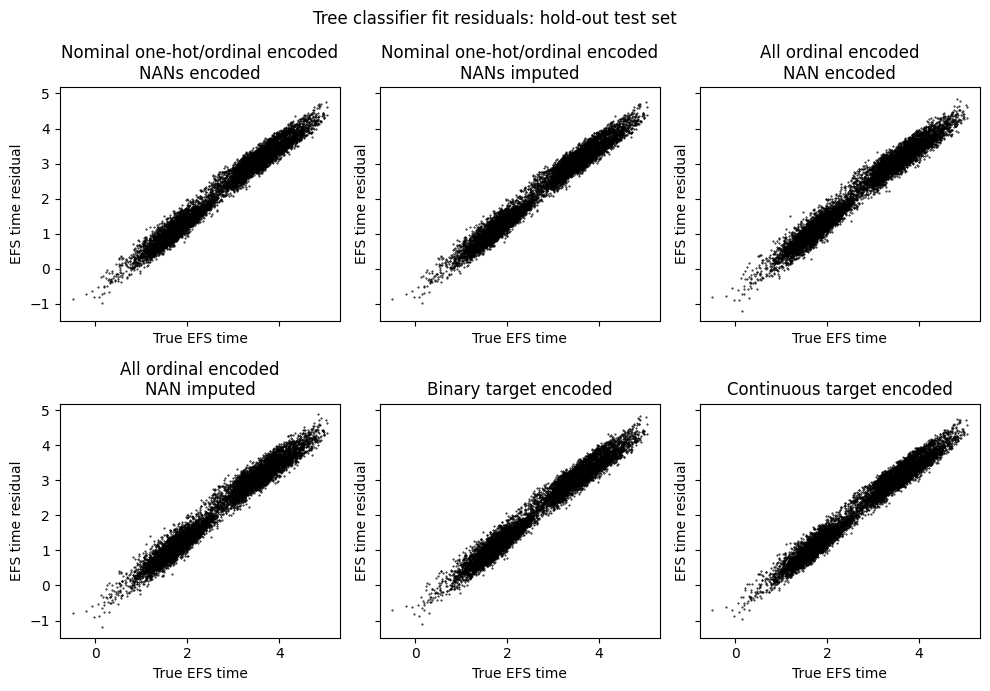

In [20]:
fig, axs=plt.subplots(2,3, figsize=(10,7), sharex=True, sharey=True)
axs=axs.flatten()

fig.suptitle('Tree classifier fit residuals: hold-out test set')

for i, dataset in enumerate(predictions.keys()):

    axs[i].set_title(dataset.replace(', ', '\n'))
    axs[i].scatter(labels[dataset]['efs_time'], labels[dataset]['efs_time'] - predictions[dataset], color='black', s=0.2)
    axs[i].set_xlabel('True EFS time')
    axs[i].set_ylabel('EFS time residual')

fig.tight_layout()
fig.savefig(datasets_test_residuals_plots, dpi=300, bbox_inches='tight')
fig.show()